In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import math

In [28]:
# clean

df = pd.read_csv("datasets/nasa_adc_2025.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12978 entries, 0 to 12977
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   MISSION ELAPSED TIME (min)  12978 non-null  float64
 1   Rx(km)[J2000-EARTH]         12978 non-null  float64
 2   Ry(km)[J2000-EARTH]         12978 non-null  float64
 3   Rz(km)[J2000-EARTH]         12978 non-null  float64
 4   Vx(km/s)[J2000-EARTH]       12978 non-null  float64
 5   Vy(km/s)[J2000-EARTH]       12978 non-null  float64
 6   Vz(km/s)[J2000-EARTH]       12978 non-null  float64
 7   MASS (kg)                   12978 non-null  float64
 8   WPSA                        12978 non-null  int64  
 9   WPSA Range                  5691 non-null   float64
 10  DS54                        12978 non-null  int64  
 11  DS54 Range                  4784 non-null   float64
 12  DS24                        12978 non-null  int64  
 13  Range DS24                  526

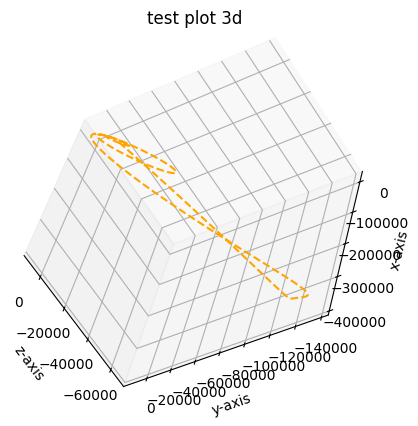

In [3]:
# 3d test
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection="3d")

z = df["Rz(km)[J2000-EARTH]"]
y = df["Ry(km)[J2000-EARTH]"]
x = df["Rx(km)[J2000-EARTH]"]

ax.plot(x,y,z, color="orange", linestyle="--")
ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")
ax.set_title("test plot 3d")

ax.view_init(elev=25,azim=-150,roll=35)
plt.show()


In [29]:
antenna_diameters = {"WPSA":12,"DS24":34,"DS34":34,"DS54":34}

satellite_transmitter_power = 10

satellite_antenna_gain = 9

losses = 19.43

ground_station_antenna_efficiency = 0.55

wavelength = 0.136363636 # speed of light / frequency

boltzman_constant = -228.6 # constant used in noise calculations 

system_noise_temperature = 222


def link_budget(range,diameter):
    inner_log1 = ground_station_antenna_efficiency * ((math.pi * diameter / wavelength) **2)
    gain_from_diameter = 10 * math.log(inner_log1,10)
    inner_log2 = (4000 * math.pi * range) / wavelength
    losses_from_range = 20 * math.log(inner_log2,10)
    losses_from_noise = 10 * math.log(system_noise_temperature,10)
    link_budget_exponent = satellite_transmitter_power + satellite_antenna_gain - losses + gain_from_diameter - losses_from_range - boltzman_constant - losses_from_noise
    link_budget_calculated = (10 ** (0.1 * link_budget_exponent)) / 1000
    return link_budget_calculated if link_budget_calculated < 10000 else 10000

antenna_connection = pd.DataFrame(columns=['minutes elapsed','shuttle_x', 'shuttle_y', 'shuttle_z','available antennas','best antenna','link budget'])

for i,n in df.iterrows():
    minutes = n['MISSION ELAPSED TIME (min)']
    x = n["Rx(km)[J2000-EARTH]"]
    y = n["Ry(km)[J2000-EARTH]"]
    z = n["Rz(km)[J2000-EARTH]"]
    available_antennas = n["WPSA"] + n["DS54"] + n["DS24"] + n["DS34"]
    l = [["WPSA","WPSA Range"],["DS54","DS54 Range"],["DS24","Range DS24"],["DS34","Range DS34"]]
    for antenna in l:
        if n[antenna[0]] != 0:
            antenna[1] = link_budget(n[antenna[1]],antenna_diameters[antenna[0]])
        else:
            antenna[1] = 0
    
    l.sort(key=lambda x: x[1],reverse=True)

    if available_antennas != 0:
        best_antenna = l[0][0]
    else:
        best_antenna = "No antenna"
    best_link_budget = l[0][1]

    row = pd.DataFrame({'minutes elapsed':minutes,'shuttle_x':x,'shuttle_y':y,'shuttle_z':z,'available antennas':available_antennas,'best antenna':best_antenna,'link budget':best_link_budget},index = [i])
    antenna_connection = pd.concat([antenna_connection,row],ignore_index=True)

# ax.scatter(antenna_connection['x'],antenna_connection["y"],antenna_connection["z"],color=antenna_connection['color'])
display(antenna_connection)

/var/folders/kn/_0ts0r255q91clr18wn1rw6m0000gp/T/ipykernel_62482/2241446194.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  antenna_connection = pd.concat([antenna_connection,row],ignore_index=True)


,minutes elapsed,shuttle_x,shuttle_y,shuttle_z,available antennas,best antenna,link budget
0,0.000000,3689.773564,4222.722170,3028.891599,1.0,WPSA,10000
1,8.236481,2319.817224,4865.712767,3698.167005,0.0,No antenna,0
2,9.236481,1865.808701,4981.749611,3862.256016,1.0,DS54,10000
3,10.236481,1402.384261,5072.667625,4006.812686,1.0,DS54,10000
4,11.236481,932.010471,5138.480400,4131.480818,1.0,DS54,10000
...,...,...,...,...,...,...,...
12973,12979.169980,6248.881412,282.551804,-3168.543102,0.0,No antenna,0
12974,12980.169980,6313.270848,532.638394,-2584.288152,0.0,No antenna,0
12975,12981.169980,6349.390572,780.327274,-1988.460146,0.0,No antenna,0
12976,12982.169980,6355.211343,1024.281185,-1383.143636,0.0,No antenna,0


In [30]:
antenna_connection.to_csv("datasets/antenna_connection.csv",index=False)

In [31]:
df = pd.read_csv("datasets/antenna_connection.csv")

print(df["best antenna"].unique())

['WPSA' 'No antenna' 'DS54' 'DS34' 'DS24']


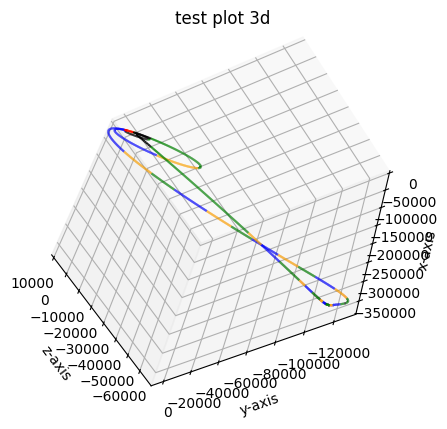

In [34]:
df = pd.read_csv("datasets/antenna_connection.csv")

fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection="3d")
color_map = {"WPSA":"red","DS24":"orange","DS34":"green","DS54":"blue","No antenna":"black"}
segment_color = df["best antenna"].map(color_map).values[:-1]

points = df[["shuttle_x","shuttle_y","shuttle_z"]].to_numpy()
segments = np.stack((points[:-1],points[1:]),axis=1)

lc = Line3DCollection(segments,colors=segment_color)
ax.add_collection(lc)

ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")
ax.set_title("test plot 3d")

ax.set_xlim(df["shuttle_x"].min(), df["shuttle_x"].max())
ax.set_ylim(df["shuttle_y"].min(), df["shuttle_y"].max())
ax.set_zlim(df["shuttle_z"].min(), df["shuttle_z"].max())
ax.view_init(elev=25,azim=-150,roll=35)
plt.show()